# Autonomous Vehicles Animal Detection

if you are running on colab, run the following cell

In [29]:
!git clone https://github.com/Giovannicus/AnimalRec.git
%cd /content/AnimalRec
%pwd

Cloning into 'AnimalRec'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 68 (delta 33), reused 39 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 731.08 KiB | 11.98 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/AnimalRec


'/content/AnimalRec'

In [30]:
import eda_batch
from logo import logo
import tarfile
import os
import numpy as np
from PIL import Image
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import RandomNormal

import plotly.graph_objects as go

In [45]:
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()

In [ ]:
logo()

# EDA

In [33]:
Y_train = (y_train >= 2) & (y_train < 8);
y_test = (y_test >= 2) & (y_test < 8);

# Preprocessing

Try printing an image

Image name leptodactylus_pentadactylus_s_000004.png
Image label 6


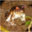

In [ ]:
image = batches["data_batch_1"]["data"][0];
red = image[:1024].reshape(32,32);
green = image[1024:2048].reshape(32,32);
blue = image[2048:].reshape(32,32);

image_rgb = np.stack((red, green, blue), axis=-1)

print("Image name "+batches["data_batch_1"]["filenames"][0])
print(f"Image label {batches["data_batch_1"]["labels"][0]}")
Image.fromarray(image_rgb)


Images will be submitted to a pipeline

### Pieplot target distribution

In [36]:
fig = go.Figure(data=[go.Pie(labels=["Animal", "Not animal"],
                             values=[np.mean(Y_train), 1 - np.mean(Y_train)],
                             hoverinfo="label+percent",  # Mostra etichetta, percentuale e valore
                             textinfo='percent',  # Mostra solo la percentuale sulle fette

                             pull=[0, 0.01],  # Evidenzia la seconda fetta
                             marker=dict(colors=['#FF0000', '#408040']),  # Colori personalizzati
                             textfont=dict(size=18)
                             )])

# Imposta il layout
fig.update_layout(
    paper_bgcolor = "rgba(0,0,0,1)",
    plot_bgcolor = "rgba(0,0,0,1)",
    title={
        'text': "Target distribution",
        'font': {'color': 'white'}
    },
    font=dict(
        color='white',
        size=18
    ),
    legend=dict(
        font=dict(color='white')
    )
)

# Mostra il grafico
fig.show()

Distribution is fairly balanced

###Data augmentation

In [47]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range=15,
    vertical_flip=True,
)

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Model

## Transfer Learning

Use pre-trained vgg16 model freezing its conv layers

In [39]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3),name="vgg16_mod")
for layer in vgg16.layers:
    layer.trainable = False
vgg16 = Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)
vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

add dense layers by yourself

In [40]:
w_init = RandomNormal(stddev=0.01)
x = vgg16.output
x = Flatten() (x)
#x = Dropout(0.2) (x)
x = Dense(1024, activation='relu') (x)
x = Dense(256, activation='relu') (x)
x = Dense(64, activation='relu') (x)
x = Dense(16, activation='relu') (x)
x = Dropout(0.2) (x)
x = Dense(1, activation='sigmoid') (x)

In [42]:
clear_session()
model = Model(inputs=vgg16.input, outputs=x,name="vgg16_mod")
model.summary()

Model: "vgg16_mod"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,092,769 (65.20 MB)

 Trainable params: 2,378,081 (9.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [43]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)


In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', "precision"])
n_epochs = 20
hist = model.fit(train_datagen.flow(x_train, y_train, batch_size=32),
              epochs=n_epochs,
              validation_data=(train_datagen.flow(x_valid, y_valid)),
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 760s 605ms/step - accuracy: 0.8234 - loss: 0.4043 - precision: 0.8393 - val_accuracy: 0.6294 - val_loss: 26.1026 - val_precision: 0.9521
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 757s 570ms/step - accuracy: 0.8538 - loss: 0.3476 - precision: 0.8682 - val_accuracy: 0.6225 - val_loss: 38.4891 - val_precision: 0.9636
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 744s 572ms/step - accuracy: 0.8691 - loss: 0.3135 - precision: 0.8823 - val_accuracy: 0.6242 - val_loss: 47.4685 - val_precision: 0.9425
Epoch 4/20
 188/1250 ━━━━━━━━━━━━━━━━━━━━ 8:26 477ms/step - accuracy: 0.8772 - loss: 0.3048 - precision: 0.8928

KeyboardInterrupt: 

In [ ]:
save("vgg16_mod.h5")
with open('training_history.json', 'w') as f:
    json.dump(hist.history, f)

In [ ]:
model = load_model('my_model.h5')
with open('training_history.json', 'r') as f:
    history = json.load(f)

# Results

Let's send output on brower avoiding visualization issues on VSC

In [ ]:
from result import plot_result

try:
  plot_result(hist)
except:
  plot(hist.history)
